In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Preparing machine learning models for real-time scoring in production environment
### Real-time scoring considerations
* How can I check incoming raw data quality on the fly?
* How can I ensure that broken data won't break my model / API?
* How can I perform feature engineering on the fly?
### What are sklearn pipelines? How can they help solve above challenges?
### How can I create a pipeline?
### How can I write my own data preprocessors and embed them in a sklearn pipeline? [Highlight]
### [Optional] Time-based train-test split and final production-ready model training
### [Optional] Using Flask and Docker to embed your model in a production-ready REST API
### [Optional] Latency testing with Locust

# ------------------------------------------------------------------------------------------------------
# PART 0
## LOADING NECESSARY SOFTWARE PACKAGES

In [22]:
### Load necessary packages
print('Loading standard Python packages...')

# General, data handling and visualization
import platform
import os
import sys
from shutil import copyfile, copytree, rmtree
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import json
%matplotlib inline

# Data preprocessing, ML model training & validation
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.externals import joblib # to save models

# Probability calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Pipelining
from sklearn.base import BaseEstimator, TransformerMixin # for definition of custom transformers
from sklearn.pipeline import Pipeline

# Datetime conversions
import datetime
import calendar

import bisect

from copy import deepcopy

# Set jupyter screen width to 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)


print('Standard Python packages successfully loaded.')

Loading standard Python packages...


Standard Python packages successfully loaded.


In [3]:
### Check package versions
print('Your system type and version of key dependencies:')

Your system type and version of key dependencies:


In [4]:
print('Operating system:', platform.system())
print('OS release:', platform.release())
print('Machine:', platform.machine())
print('Platform:', platform.platform())
print('Version:', platform.version())
print()
print('Python version: {}'.format(sys.version))
print('Pandas version: {}'.format(pd.__version__))
print('Numpy version: {}'.format(np.__version__))
print('Scikit-learn version: {}'.format(sklearn.__version__))

Operating system: Linux
OS release: 4.15.0-99-generic
Machine: x86_64
Platform: Linux-4.15.0-99-generic-x86_64-with-debian-buster-sid
Version: #100-Ubuntu SMP Wed Apr 22 20:32:56 UTC 2020

Python version: 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
Pandas version: 0.24.2
Numpy version: 1.16.3
Scikit-learn version: 0.20.3


In [5]:
### Load helper functions
print('Importing custom helper functions...')

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.library.helper_functions import predict, validate, plot_ROC_curve, plot_precision_recall_curve

print('Helper functions imported.')

Importing custom helper functions...
Helper functions imported.


In [6]:
### Load widget class that allows the user to browse for the data file to be used
#print('Importing custom FileBrowser widget...')

#from src.library.select_file import FileBrowser 

#print('FileBrowser widget imported.')

In [7]:
### Load custom preprocessing transformers - to be used in the pipeline later on
print('Importing custom data preprocessors...')

from src.library.pipeline_components import WhitespaceRemover, CastToOriginalDtypes, CastToUserDtypes, CheckForUnseenValues, DfToDict
from src.library.pipeline_components import IntegerEncoder, DayOfWeekEncoder, DeviceEncoder, FeatureRemover, AgeEncoder

print('Custom preprocessors imported.')

Importing custom data preprocessors...
Custom preprocessors imported.


In [8]:
### Set up the training & prediction pipeline

print('Setting up model training and prediction pipelines...')

# Create random forest classifier object
RF_clf = RandomForestClassifier(n_estimators=100, # different than default, default = 10
                                criterion='gini',
                                max_depth=None, # Changed to 100 to limit the depth of each tree..
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features=1, # different than default, default = 'auto'
                                max_leaf_nodes=None,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=-1, # use all available cores
                                random_state=0, # define random state for reproducibility of results
                                verbose=0,
                                warm_start=False,
                                class_weight=None)

## Create pipeline - no calibration
RF_pipeline_uncalibrated = Pipeline([('whitespaceremoval', WhitespaceRemover()),
                                    ('originaldtypescasting', CastToOriginalDtypes()),
                                    ('deviceencoder', DeviceEncoder()),
                                    ('ageencoder', AgeEncoder()),
                                    ('dayofweekencoder', DayOfWeekEncoder()),
                                    ('userdtypescasting', CastToUserDtypes()),
                                    ('unseenvalueschecker', CheckForUnseenValues()),
                                    ('featureremoval', FeatureRemover()),
                                    ('dicttransformer', DfToDict()),
                                    ('ohe', DictVectorizer()),
                                    ('imputation', Imputer(missing_values='NaN', strategy='most_frequent')),
                                    ('scaling', StandardScaler(with_mean=False)),
                                    ('classifier', RF_clf)])

## Isotonic calibration
RF_pipeline_isotonic = Pipeline([('whitespaceremoval', WhitespaceRemover()),
                                    ('originaldtypescasting', CastToOriginalDtypes()),
                                    ('deviceencoder', DeviceEncoder()),
                                    ('ageencoder', AgeEncoder()),
                                    ('dayofweekencoder', DayOfWeekEncoder()),
                                    ('userdtypescasting', CastToUserDtypes()),
                                    ('unseenvalueschecker', CheckForUnseenValues()),
                                    ('featureremoval', FeatureRemover()),
                                    ('dicttransformer', DfToDict()),
                                    ('ohe', DictVectorizer()),
                                    ('imputation', Imputer(missing_values='NaN', strategy='most_frequent')),
                                    ('scaling', StandardScaler(with_mean=False)),
                                    #('classifier', RF_clf)])
                                    ('classifier', CalibratedClassifierCV(base_estimator=RF_clf, cv=2, method='isotonic'))])

## Sigmoid calibration
RF_pipeline_sigmoid = Pipeline([('whitespaceremoval', WhitespaceRemover()),
                                    ('originaldtypescasting', CastToOriginalDtypes()),
                                    ('deviceencoder', DeviceEncoder()),
                                    ('ageencoder', AgeEncoder()),
                                    ('dayofweekencoder', DayOfWeekEncoder()),
                                    ('userdtypescasting', CastToUserDtypes()),
                                    ('unseenvalueschecker', CheckForUnseenValues()),
                                    ('featureremoval', FeatureRemover()),
                                    ('dicttransformer', DfToDict()),
                                    ('ohe', DictVectorizer()),
                                    ('imputation', Imputer(missing_values='NaN', strategy='most_frequent')),
                                    ('scaling', StandardScaler(with_mean=False)),
                                    #('classifier', RF_clf)])
                                    ('classifier', CalibratedClassifierCV(base_estimator=RF_clf, cv=2, method='sigmoid'))])
                                

print('Model training and prediction pipelines set up.')

Setting up model training and prediction pipelines...
Model training and prediction pipelines set up.


 /home/tomek/anaconda3/envs/credit-scoring-tma/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning:Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead. 
 /home/tomek/anaconda3/envs/credit-scoring-tma/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning:Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead. 
 /home/tomek/anaconda3/envs/credit-scoring-tma/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning:Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead. 


# ------------------------------------------------------------------------------------------------------
# PART 1
## LET'S HAVE A LOOK AT THE DATA

### We will be using a modified open-source German credit scoring dataset
Original dataset is available under https://www.kaggle.com/uciml/german-credit/data

In [9]:
#print('Please select the data file that should be used for model training:')
#datafile = FileBrowser()
#datafile.widget()

In [10]:
# Load ORIGINAL full TMA dataset
print('Reading in selected file...')
# Uncomment the below read_csv statement to load a test sample of the data, for a test run of the notebook
#df = pd.read_csv('../data/interim/np_training_2_downsampled.csv',
#                 parse_dates=['PURCHASE_DATE', 'BIRTHDATE'],
#                 low_memory=False)

# Uncomment the below read_csv statement to load the full TMA dataset
df = pd.read_csv('../data/kaggle_german_credit_data_original_with_label.csv',
                 #sep='\t',
                 #decimal=',',
                 #parse_dates=['PURCHASE_DATE', 'BIRTHDATE'],
                 #encoding='ISO-8859-1',
                 low_memory=False)

print('File successfully read in. Analyzing...')

print('Table dimensions:')
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])
print()
pd.set_option("display.max_columns", df.shape[1])
pd.set_option("display.max_rows", df.shape[1])
print('Overview of the first five table rows:')
display(df.head())
print('Overview of the last five table rows:')
display(df.head())
# print('Column datatypes:')
# print(df.dtypes)

Reading in selected file...
File successfully read in. Analyzing...
Table dimensions:
Number of rows: 1000
Number of columns: 11

Overview of the first five table rows:


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


Overview of the last five table rows:


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


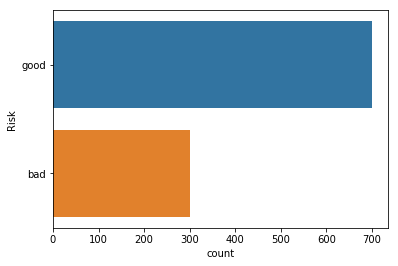

good    700
bad     300
Name: Risk, dtype: int64

In [11]:
sns.countplot(y='Risk', data=df)
plt.show()
display(df['Risk'].value_counts())

In [12]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['Gender'] = df['Sex']
df.drop(['Sex'], axis=1, inplace=True)
df.head()

,Age,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Gender
0,67,2,own,NaN,little,1169,6,radio/TV,good,male
1,22,2,own,little,moderate,5951,48,radio/TV,bad,female
2,49,1,own,little,NaN,2096,12,education,good,male
3,45,2,free,little,little,7882,42,furniture/equipment,good,male
4,53,2,free,little,little,4870,24,car,bad,male


In [13]:
datetime.datetime.now()

datetime.datetime(2020, 5, 17, 9, 35, 25, 997615)

In [14]:
df['Purchase_date'] = datetime.datetime.now()

In [15]:
def random_dates(start, end, n=1):

    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s').date[0]

In [16]:
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2020-05-15')
random_dates(start_date, end_date)

datetime.date(2020, 2, 1)

In [17]:
df['Purchase_date'] = df.apply(lambda row : random_dates(start_date, end_date), axis=1)
df['Purchase_date'] = pd.to_datetime(df['Purchase_date'])

In [18]:
def generate_birth_date(row):
    purchase_date = row['Purchase_date']
    age_years = row['Age']
    
    return purchase_date - pd.DateOffset(years=age_years)

df['Birth_date'] = df.apply(lambda row : generate_birth_date(row), axis=1)
df['Birth_date'] = pd.to_datetime(df['Birth_date'])

In [19]:
import random
def allocate_device(device_lst):
    return random.choice(device_lst)

In [24]:
device_list = [
    'iPhone 10 Black',
    'iPhone 11 Black',
    'iPhone 10 White',
    'iPhone 11 Black',
    'iPhone 9',
    'Samsung Amazing',
    'Huawei Great',
    'Nokia Old',
    'Samsung Fantastic',
    'Huawei Fantastic',
    'Samsung Awesome',
    'Huawei Awesome',
    'Nokia Very Old',
    'Ericsson Very Old',
    'One Plus 8 128 GB',
    'OPPO Find X2 256 GB',
    'OPPO Reno 2'
]

df['Device'] = df.apply(lambda row : allocate_device(device_list), axis=1)

In [27]:
df.head(20)

,Age,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Gender,Purchase_date,Birth_date,Device,risk_label
0,67,2,own,NaN,little,1169,6,radio/TV,good,male,2020-01-22,1953-01-22,One Plus 8 128 GB,0
1,22,2,own,little,moderate,5951,48,radio/TV,bad,female,2020-04-17,1998-04-17,iPhone 10 Black,1
2,49,1,own,little,NaN,2096,12,education,good,male,2020-04-06,1971-04-06,Samsung Fantastic,0
3,45,2,free,little,little,7882,42,furniture/equipment,good,male,2020-01-19,1975-01-19,Samsung Amazing,0
4,53,2,free,little,little,4870,24,car,bad,male,2020-01-06,1967-01-06,OPPO Reno 2,1
5,35,1,free,NaN,NaN,9055,36,education,good,male,2020-01-27,1985-01-27,iPhone 10 Black,0
6,53,2,own,quite rich,NaN,2835,24,furniture/equipment,good,male,2020-03-15,1967-03-15,iPhone 10 White,0
7,35,3,rent,little,moderate,6948,36,car,good,male,2020-03-24,1985-03-24,OPPO Find X2 256 GB,0
8,61,1,own,rich,NaN,3059,12,radio/TV,good,male,2020-02-20,1959-02-20,iPhone 11 Black,0
9,28,3,own,little,moderate,5234,30,car,bad,male,2020-02-28,1992-02-28,iPhone 11 Black,1


In [28]:
def generate_label(row):
    risk = row['Risk']
    if risk == 'good':
        return 0
    else:
        return 1

df['Risk_label'] = df.apply(lambda row : generate_label(row), axis=1)
df.head()

,Age,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Gender,Purchase_date,Birth_date,Device,risk_label,Risk_label
0,67,2,own,NaN,little,1169,6,radio/TV,good,male,2020-01-22,1953-01-22,One Plus 8 128 GB,0,0
1,22,2,own,little,moderate,5951,48,radio/TV,bad,female,2020-04-17,1998-04-17,iPhone 10 Black,1,1
2,49,1,own,little,NaN,2096,12,education,good,male,2020-04-06,1971-04-06,Samsung Fantastic,0,0
3,45,2,free,little,little,7882,42,furniture/equipment,good,male,2020-01-19,1975-01-19,Samsung Amazing,0,0
4,53,2,free,little,little,4870,24,car,bad,male,2020-01-06,1967-01-06,OPPO Reno 2,1,1


In [29]:
df.drop(['risk_label', 'Risk'], axis=1, inplace=True)

In [30]:
df.drop(['Age'], axis=1, inplace=True)

In [31]:
df.to_csv('../data/kaggle_german_credit_data_modified.csv', index=False)

# APPROACH 1: STANDARD, BY-THE-BOOK TRAINING OF A MACHINE LEARNING MODEL (SIMPLIFIED)

## DATA EXPLORATION
### We will be using a modified open-source German credit scoring dataset. This is a "faked" dataset, used here for demo purposes only(!)
Original dataset is available under https://www.kaggle.com/uciml/german-credit/data

Reading in selected file...
File successfully read in. Analyzing...

Table dimensions:
Number of rows: 1000
Number of columns: 12

Overview of the first five table rows:


,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device,Risk_label
0,2,own,NaN,little,1169,6,radio/TV,male,2020-01-22,1953-01-22,One Plus 8 128 GB,0
1,2,own,little,moderate,5951,48,radio/TV,female,2020-04-17,1998-04-17,iPhone 10 Black,1
2,1,own,little,NaN,2096,12,education,male,2020-04-06,1971-04-06,Samsung Fantastic,0
3,2,free,little,little,7882,42,furniture/equipment,male,2020-01-19,1975-01-19,Samsung Amazing,0
4,2,free,little,little,4870,24,car,male,2020-01-06,1967-01-06,OPPO Reno 2,1



Summary of numeric features


,Job,Credit amount,Duration,Risk_label
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.904000,3271.258000,20.903000,0.300000
std,0.653614,2822.736876,12.058814,0.458487
min,0.000000,250.000000,4.000000,0.000000
25%,2.000000,1365.500000,12.000000,0.000000
50%,2.000000,2319.500000,18.000000,0.000000
75%,2.000000,3972.250000,24.000000,1.000000
max,3.000000,18424.000000,72.000000,1.000000



Summary of categorical features


,Housing,Saving accounts,Checking account,Purpose,Gender,Purchase_date,Birth_date,Device
count,1000,817,606,1000,1000,1000,1000,1000
unique,3,4,3,8,2,134,895,16
top,own,little,little,car,male,2020-05-07 00:00:00,1997-02-13 00:00:00,iPhone 11 Black
freq,713,603,274,337,690,14,4,117
first,NaN,NaN,NaN,NaN,NaN,2020-01-01 00:00:00,1945-01-09 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,2020-05-14 00:00:00,2001-05-11 00:00:00,NaN



Number of missing values per column:


Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Gender                0
Purchase_date         0
Birth_date            0
Device                0
Risk_label            0
dtype: int64


Number of high risk (label == 1) vs. low risk (label == 0) applicants:


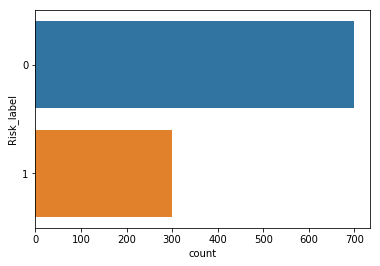

0    700
1    300
Name: Risk_label, dtype: int64


Distribution of devices used:


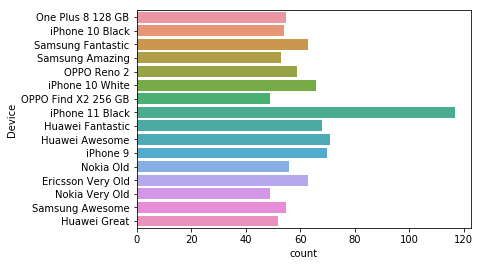


Number of unique values in the "Job" column:


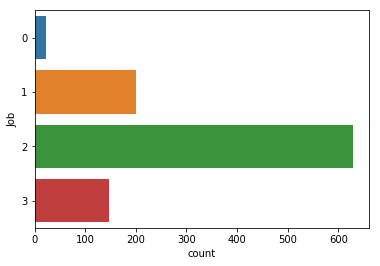

In [42]:
# Load dataset
print('Reading in selected file...')
df = pd.read_csv('../data/kaggle_german_credit_data_modified.csv',
                 parse_dates = ['Purchase_date', 'Birth_date'],
                 low_memory=False)

print('File successfully read in. Analyzing...')
print()
print('Table dimensions:')
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])
print()
print('Overview of the first five table rows:')
display(df.head())
#print('Column datatypes:')
#print(df.dtypes)
print()
print('Summary of numeric features')
display(df.describe())
print()
print('Summary of categorical features')
display(df.describe(include=['object', 'datetime']))
print()
print('Number of missing values per column:')
display(df.isna().sum())
print()
print('Number of high risk (label == 1) vs. low risk (label == 0) applicants:')
sns.countplot(y='Risk_label', data=df)
plt.show()
display(df['Risk_label'].value_counts())
print()
print('Distribution of devices used:')
sns.countplot(y='Device', data=df)
plt.show()
print()
print('Number of unique values in the "Job" column:')
sns.countplot(y='Job', data=df)
plt.show()

### --> You would normally take many more data exploration steps, we skip them here for the sake of brevity.

### Your initial conclusions (example):
* I will need to deal with missing values in savings account and checking account columns
* Purchase date and birth date columns have very high cardinality, and in general dates should not be used as-is in model training. I will need to recode these columns into something useful.
* A credit risk analyst told me that the risk profile of iPhone users is different than that of people using other devices. I want to recode the Device column in iPhone vs. other devices.
* The job column looks like an integer-encoded categorical feature
* ...

## DATA CLEANING

## FEATURE ENGINEERING

## MODEL TRAINING & EVALUATION

## HOW DO I REPRODUCE THIS STEPS IN THE PRODUCTION ENVIRONMENT?

In [ ]:
#pd.to_datetime(df['BIRTHDATE'].replace('nan', np.nan))
#df['BIRTHDATE'].sort_values(ascending=False).replace('nan', np.nan).head(14270)
#df.loc[df['BIRTHDATE'] == '01.07.50']

#for index, row in df.iterrows():
#    try:
#        pd.to_datetime(row['BIRTHDATE'])
#    except:
#        print(index)
#        print(row)

In [ ]:
#from sklearn.utils import resample
#df_downsampled = resample(df, n_samples=10000, replace=False, random_state=0)
#df_downsampled.to_csv('../data/interim/np_training_2_downsampled.csv', index=False)

## STEP 1
### Check for and remove duplicates

In [ ]:
# Check for duplicates
# Select duplicate rows except first occurrence based on all columns

print('Checking for duplicates...')
duplicateRowsDF = df[df.duplicated()]
if duplicateRowsDF.shape[0] == 0:
    print("Good news - no duplicates found.")
else:
    print('Duplicate rows found!')
    print('Number of duplicate rows:', duplicateRowsDF.shape[0])
    duplicateRowsDF = df[df.duplicated(keep=False)]
    duplicateRowsIndices = duplicateRowsDF.index
    #duplicateRowsIndices = duplicateRowsDF.groupby(duplicateRowsDF.columns.tolist()).apply(lambda x: tuple(x.index)).tolist()
    print('Indices of duplicate rows:')
    print(duplicateRowsIndices)
    print('Removing duplicate rows except for the first occurrence...')
    df.drop_duplicates(subset=None, keep='first', inplace=True)
    print('Done.')
    print('After removing duplicates, the table now has', df.shape[0], 'rows.')

In [ ]:
# TODO: Potentially add some more sanity checks here

## STEP 2
### Remove customers who didn't accept the offer / didn't sign the contract

In [ ]:
# Count customers per status
print('Checking what customer status is available in the data - overview of potential status codes:')
print('5 = zurückgelegt (customer did not accept the offer / did not sign the contract')
print('15 = abgelehnt (customer REJECTED)')
print('100, 110 = freigeschalten (customer ACCEPTED)')
print('75 = ?')
sns.countplot(y="STATUS_ID", data=df)
plt.show()
display(df['STATUS_ID'].value_counts())

In [ ]:
# Remove status "5" customers (status == 5) and ALSO status == 75
print('Removing customers with status == 5 and status == 75...')
df_relevant = df[~df['STATUS_ID'].isin([5, 75])].copy()

# Count customers per status
print('Overview of the status codes after removing 5 and 75:')
sns.countplot(y="STATUS_ID", data=df_relevant)
plt.show()
display(df_relevant['STATUS_ID'].value_counts())

## STEP 3
### Remove labels for the rejected customers (critical!)

In [ ]:
## Remove labels for the rejected customers
print('Original number of defaulters and non-defaulters:')
display(df_relevant['NEVERPAYER'].value_counts())
print('Removing labels for rejected customers...')
df_relevant_empty_labels = df_relevant.copy()
df_relevant_empty_labels['NEVERPAYER'] = np.where(df_relevant_empty_labels['STATUS_ID']==15, np.nan, df_relevant_empty_labels['NEVERPAYER'])
print('Number of defaulters and non-defaulters after ensuring rejected customers have empty label values:')
display(df_relevant_empty_labels['NEVERPAYER'].value_counts())

## STEP 4
### Create "BIRTH_MONTH" column - based on the "BIRTHDATE" column - to support column name and to format known to CRIF

In [ ]:
df_relevant_empty_labels['BIRTHDATE'] = pd.to_datetime(df_relevant_empty_labels['BIRTHDATE'])
#df['BIRTHDATE'].sort_values(ascending=False).replace('nan', np.nan).head(14270)
#df.loc[df['BIRTHDATE'] == '01.07.50']

#for index, row in df.iterrows():
#   try:
#        pd.to_datetime(row['BIRTHDATE'])
#    except:
#        print(index)
#        print(row)

In [ ]:
#df_relevant_empty_labels.info()

In [ ]:
print('Creating the BIRTH_MONTH column in format YYYY.MM instead of YYYY-MM-DD...')
df_relevant_empty_labels['BIRTH_MONTH'] = df_relevant_empty_labels['BIRTHDATE'].map(lambda x: (100*x.year + x.month)/100)
print('Done.')
print('Overview of first 5 rows including the new BIRTH_MONTH column')
display(df_relevant_empty_labels.head())

## STEP 5
### Add "TAC" column - which is not available in the current data, but will be used in the future and is required as an input by CRIF. This column will be filled with a dummy value.

In [ ]:
print('Adding "TAC" column and filling it with dummy data...')
df_relevant_empty_labels.loc[:, 'TAC'] = '35602508'
print('Done.')
print('Overview of first 5 rows including the new TAC column')
display(df_relevant_empty_labels.head())

## STEP 6
### Selecting columns which should be used for model training, i.e. are available in CRIF production environment

In [ ]:
print('Selecting columns...')
df_final_tool_input = df_relevant_empty_labels[['AKZ', # Erweiterung
                                               'DEVICE_PRICE', # Erweiterung
                                               'MNP_YN', # Erweiterung
                                               'COUNTRY', # CRIF
                                               'IDENTIFICATION_TYPE', # CRIF
                                               #'CNT_NOFEE_OPTIONS', # NOT ON LIST
                                               #'INSTALLMENT_TYPE', # NOT ON LIST
                                               'ISO', # CRIF
                                               #'CNT_FEE_OPTIONS', # NOT ON LIST
                                               'BIN', # CRIF
                                               'ZIP', # CRIF
                                               'GENDER', # CRIF
                                               #'KAUTION', # gestrichen
                                               'PURCHASE_HOUR', # Erweiterung
                                               'BILL_ONLINE_YN', # Erweiterung
                                               #'VALUE_NONREC_FEE', # NOT ON LIST
                                               'LIABILITY', # Erweiterung
                                               'TARIF_FEE', # Erweiterung
                                               'PURCHASE_DATE', # Erweiterung - NO PREDICTIVE VALUE IN THIS FORMAT, TOO MANY UNIQUE VALUES
                                               'BIRTH_MONTH', # CRIF, TO BE CLARIFIED, format is just the month number
                                               #'BIRTHDATE', # NOT ON LIST, TO BE CLARIFIED, format is a full date (not year)
                                               'STATUS_ID', # gestrichen, but we keep it for benchmarking purposes
                                               'MVD_MONTHS', # Erweiterung
                                               #'CNT_INSURANCE', # NOT ON LIST
                                               'DEALER_CODE', # CRIF
                                               #'VALUE_INSURANCE_FEE', # NOT ON LIST
                                               #'SIMLOCK_FLAG', # NOT ON LIST
                                               'DEVICE_MODEL_TYPE', # Erweiterung
                                               'SEGMENT_TARIF', # Erweiterung
                                               'TARIF_ID', # CRIF
                                               #'CNT_INTERLOCK', # NOT ON LIST
                                               'MEMORY_SIZE', # Erweiterung
                                               'VOLLJAEHRIG', # CRIF
                                               'AUSWEISVORH', # CRIF
                                               'CITY', # CRIF - think about some smart encoding here
                                               #'VALUE_RECURRING_FEE', # NOT ON LIST
                                               #'CRIF_DECISION', # NOT ON LIST
                                               'KLAX_MAX_UMSTEIGER_PRE2POST', # Erweiterung
                                               'PAYMENT', # CRIF
                                               'DEVICE_INFO', # Erweiterung - consider smart encoding or removing
                                               'REDUKTION', # Erweiterung
                                               'CRIF_SCORE', # CRIF
                                               'CONTRACT_INFO', # Erweiterung
                                               'BRAND', # CRIF
                                               'DEPOSIT', # Erweiterung
                                               'NEVERPAYER', # LABEL
                                               'TAC']].copy() # New colunn with dummy data - column required by CRIF

print('Done.')
print('Final table with only columns that will be used for model training - first five rows:')
display(df_final_tool_input.head())

## STEP 7
### Specifying decision column and label column

In [ ]:
print('Specifying decision column and label column...')
## Decision column assumed to not exist unless specified by the user
decision_column = None
label_column = None

## User specifies which column is the decision column
decision_column = 'STATUS_ID'
label_column = 'NEVERPAYER'
print('Done.')

In [ ]:
# Create "lean" dataframe that will be used in next steps
#print('Creating lean dataframe including only columns needed for model training and evaluation...')
#input_cols.extend(decision_columns)
#input_cols.extend([label_column])
#df_relevant = df[input_cols].copy()
#print('Done.')

# TODO: for model retraining, 
# a cross-check whether column names and dtypes are the same as in the first training should be included

In [ ]:
### Removing completely empty columns:
# Number of missing values per column
#print('Checking whether there are empty columns...')
#completely_empty_cols = []
#for index, value in df.isnull().sum().iteritems():
#    if value == df.shape[0]:
#        completely_empty_cols.append(index)
        
#print('Completely empty columns found. They are going to be removed:')
#print(completely_empty_cols)
#print('Removing empty columns...')
#df_relevant.drop(completely_empty_cols, inplace=True, axis=1)
#print('Done.')

In [ ]:
#display(df_relevant.head())

# ------------------------------------------------------------------------------------------------------
# PART 2
## DATA PREPROCESSING AND MODEL TRAINING

In [ ]:
#df_final_tool_input = df_relevant.copy()
print('Overview of the number of defaulters (label = 1) vs good customers (label = 0)')
sns.countplot(y=label_column, data=df_final_tool_input)
plt.show()

------------------
## STEP 1
### Split data into "model_data" (to be used for model training and biz case) and "bc_only_data" (biz case only)

In [ ]:
## Updated MLB flow - only if decision_column is not None(!). Otherwise standard training as before.

## Step 1: Split data into "model_data" and "bc_only_data"
print('Splitting data into "model_data" and "bc_only_data"...')

# model_data == data which has a label (might include some rejected customers)
model_data = df_final_tool_input[df_final_tool_input[label_column].notnull()]
print('Number of rows in the "model_data":', model_data.shape[0])
#display(model_data.shape)

# bc_only_data == data which has no label (assumed to be only rejected customers)
bc_only_data = df_final_tool_input[df_final_tool_input[label_column].isnull()]
print('Number of rows in the "bc_only_data":', bc_only_data.shape[0])
#display(bc_only_data.shape)

--------------
## STEP 2
### Split "model data" into training and testing set
#### NOTE: TEST SET SIZE = 25% OF "MODEL_DATA" RECOMMENDED 

In [ ]:
## Step 2: Train-test split model data
print('Splitting "model_data" into training and testing set...')
train_set, test_set = train_test_split(model_data, test_size=0.25, random_state=42)
print('Done.')

# At this point we have three data subsets: training data, test data (for evaluating the model),
# bc_only data (data without labels, for business case purposes only)
# Next, we use the first two subsets to run MLB training and testing - with minor modifications due to decision column.

------------------
## STEP 3
### Upsample the minority class in the training set
#### (this step is not appllied to TMA dataset due to its incompatibility with probability calibration)

In [ ]:
'''
## Step 3: Upsample the minority class in the training set
print('Upsampling the minority class (neverpayers) in the training set...')
# Check how many neverpayers and payers we have
print('Training set - before upsampling - number of labels 0 and 1:')
display(train_set[label_column].value_counts())
print()
print('Test set:')
display(test_set[label_column].value_counts())
print()

# Separate majority and minority classes
train_majority = train_set[train_set[label_column]==0]
train_minority = train_set[train_set[label_column]==1]
 
# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples=train_majority.shape[0],  # to match majority class
                                    random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
train_set_upsampled = pd.concat([train_majority, train_minority_upsampled])
 
# Display new class counts
print('Training set - after upsampling:')
display(train_set_upsampled[label_column].value_counts())

print('Upsampling completed.')
'''

------------------
## STEP 4
### Read in feature types (defined manually here, normally to be specified on the frontend by the user)

In [ ]:
# TODO: Build a widget that allows the user to change feature type allocation (not relevant for model retraining)
### Step 4 - define feature types - NORMALLY THIS COMES FROM THE FRONTEND
print('Specifying feature types...')

feature_types_df = pd.DataFrame(index = df_final_tool_input.nunique().index, columns = ['feature_type'])

categorical_features = df_final_tool_input.select_dtypes(include=['object']).nunique().index.values
numerical_features = df_final_tool_input.select_dtypes(exclude=['object']).nunique().index.values

#display(categorical_features)
#display(numerical_features)

for index in feature_types_df.index.values:
    if index in categorical_features:
        feature_types_df.loc[index, 'feature_type'] = 'categorical'
    elif index in numerical_features:
        feature_types_df.loc[index, 'feature_type'] = 'numerical'
    else:
        print('ERROR')

# Drop label_column and decision_column from feature list
cols_to_drop = [decision_column, label_column]
feature_types_df.drop(cols_to_drop, inplace = True)

#display(feature_types_df)
#print()

## Manually change some of feature types
feature_types_df.loc['COUNTRY', 'feature_type'] = 'categorical'
feature_types_df.loc['GENDER', 'feature_type'] = 'categorical'
feature_types_df.loc['PURCHASE_DATE', 'feature_type'] = 'categorical'
feature_types_df.loc['TARIF_ID', 'feature_type'] = 'categorical'
feature_types_df.loc['SEGMENT_TARIF', 'feature_type'] = 'categorical'

feature_types = feature_types_df.to_dict()['feature_type']
#display(feature_types)

## Generate a few lists which will be useful later on
feature_names_list = list(feature_types.keys())
feature_types_list = list(feature_types.values())

#display(feature_names_list)
#display(feature_types_list)

categorical_features = []
numerical_features = []
categorical_feature_indices = []

for feature_index, feature_type in enumerate(feature_types_list):
    if feature_type == 'categorical':
        categorical_features.append(feature_names_list[feature_index])
        categorical_feature_indices.append(feature_index)
    else:
        numerical_features.append(feature_names_list[feature_index])

print('Categorical features:')
display(categorical_features)
print()
print('Numeric features:')
display(numerical_features)
print('Feature types specified.')

In [ ]:
### OPTIONAL: Generate feature types metadata (to be used in the prediction API later on)
#count = 0
#features_metadata = []
#for index in feature_types_df.index.values:
#    features_metadata.append({
#        'name': index,
#        'type': feature_types_df.loc[index, 'feature_type'],
#        'index': count
#    })
#    count += 1
#display(features_metadata)

#import json
#json_dump = json.dumps(features_metadata)
#print(json_dump)

---------------
## STEPS 5, 6, 7
### Prepare data for training, fit the pipeline (train model), test the pipeline (evaluate model)

In [ ]:
### Step 5: Prepare data for training in dataframe format - this is the format from which conversion to a dict is easy
print('Splitting the data into features and labels...')

# With upsampling:
#features_train = train_set_upsampled.drop(cols_to_drop, axis=1)
#labels_train = train_set_upsampled[[label_column]]

# Without upsampling
features_train = train_set.drop(cols_to_drop, axis=1)
labels_train = train_set[[label_column]]

features_test = test_set.drop(cols_to_drop, axis=1)
labels_test = test_set[[label_column]]

print('Done.')

In [ ]:
def fit_and_validate(pipeline):
    ### Step 6: Fit the pipeline
    print('Fitting the pipeline (model training)... ')
    print('This can take around 20-40 mins on TMA dataset depending on available computing power...')
    pipeline.fit(features_train,
                labels_train.values.ravel(),
                userdtypescasting__feature_types=feature_types_list,
                unseenvalueschecker__feature_types=feature_types_list)
    print('Pipeline fitting completed.')

    ### Step 7: Test the pipeline by making predictions and computing metrics
    print('Validating the pipeline (evaluating the model)...')
    print('Model evaluation results:')
    validate(pipeline, features_test, labels_test)
    print('Pipeline validated.')

In [ ]:
%%time
### Run model training and evaluation - this can take some time
# TODO: Consider adding progress / countdown widget / stopclock
fit_and_validate(RF_pipeline_uncalibrated)

In [ ]:
%%time
### Run model training and evaluation - this can take some time
# TODO: Consider adding progress / countdown widget / stopclock
fit_and_validate(RF_pipeline_isotonic)

In [ ]:
%%time
### Run model training and evaluation - this can take some time
# TODO: Consider adding progress / countdown widget / stopclock
fit_and_validate(RF_pipeline_sigmoid)

In [ ]:
# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(RF_pipeline_uncalibrated, 'Uncalibrated'),
                  (RF_pipeline_isotonic, 'Isotonic calibration'),
                  (RF_pipeline_sigmoid, 'Sigmoid calibration')]:
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(features_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(features_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(labels_test, prob_pos, n_bins=20)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=20, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [ ]:
#### TO JUST COMPARE CALIBRATION RESULTS STOP RUNNING CODE HERE

In [ ]:
model_training_timestamp = '{:%Y-%b-%d_%H:%M:%S}'.format(datetime.datetime.now())
print('Model training completed on ', model_training_timestamp,'.')
print('Creating dedicated output directory...')
dirName = '../output/%s/' % (model_training_timestamp)
 
try:
    # Create target Directory
    os.mkdir(dirName)
    os.mkdir(dirName+'standalone-deployment')
    os.mkdir(dirName+'business-case-data')
    print("Directory " , dirName ,  "successfully created.")
except FileExistsError:
    print("ERROR: Directory " , dirName ,  "already exists!")

In [ ]:
### Assign generic name "RF_pipeline" to selected pipeline
# For the initial deployment, the uncalibrated model version was used.
# However, in the future, the calibrated version might do a better job
RF_pipeline = RF_pipeline_uncalibrated

In [ ]:
### Persist model, and model training and validation data
# TODO: Make sure old model doesn't get overwritten in case someone is retraining the model
print('Saving model and auxiliary data into ', dirName)
#joblib.dump(RF_pipeline_uncalibrated, dirName+'standalone-deployment/RF_pipeline_uncalibrated.pkl')
#joblib.dump(RF_pipeline_isotonic, dirName+'standalone-deployment/RF_pipeline_isotonic.pkl')
joblib.dump(RF_pipeline, dirName+'standalone-deployment/RF_pipeline.pkl')
#joblib.dump(features_train, '../output/sample_features_train.pkl')
#joblib.dump(labels_train, '../output/sample_labels_train.pkl')
#joblib.dump(features_test, '../output/sample_features_test.pkl')
#joblib.dump(labels_test, '../output/sample_labels_test.pkl')

In [ ]:
### Read-in model
# Uncomment the below code if you want to read in the already saved model
#RF_pipeline = joblib.load('../output/2019-Aug-22_21:38:03/standalone-deployment/RF_pipeline.pkl')

--------------
## STEP 8
### Make probability predictions on test data

In [ ]:
### Step 8: Make probability predictions on test data
print('Making predictions on test data...')
test_set_predictions = RF_pipeline.predict_proba(features_test)[:,1]
print('Done.')
print('Distribution of predicted probabilities:')
sns.violinplot(test_set_predictions)
plt.show()

------------------
## STEP 9
### Make probability predictions on "bc_only" data

In [ ]:
### Step 9: Make probability predictions on "bc_only" data
print('Making predictions on bc_only data...')
features_bc_data_only = bc_only_data.drop([label_column], axis=1)
print('Done.')
print('Distribution of predicted probabilities:')
bc_only_data_predictions = RF_pipeline.predict_proba(features_bc_data_only)[:,1]
sns.violinplot(bc_only_data_predictions)
plt.show()

-----------------
## STEP 10
### Combine predictions with respective original data subsets (i.e. assign samples to predictions)

In [ ]:
## Step 10: Combine predictions with respective data subsets
print('Combining predictions with test and bc_only datasets...')
test_set_with_predictions = test_set.copy()
test_set_with_predictions['MLB_PD'] = test_set_predictions
#display(test_set_with_predictions.head())

bc_only_data_with_predictions = bc_only_data.copy()
bc_only_data_with_predictions['MLB_PD'] = bc_only_data_predictions
#display(bc_only_data_with_predictions.head())

print('Done.')

-------------------
## STEP 11
### Upsample test set x4 (to be in correct relation to the "bc_only" data)
#### Note: BASED ON THE ASSUMPTION TEST SET SIZE == 25% MODEL_DATA SIZE (!!!)

In [ ]:
### Step 11: Upsample test set x4 (to be in correct relation to the "bc_only" data)
print('Upsampling test set x4...')
print('Size of the test set before upsampling:')
display(test_set_with_predictions.shape)
test_set_with_predictions_upsampled = test_set_with_predictions.copy()
for i in range(3):
    test_set_with_predictions_upsampled = test_set_with_predictions_upsampled.append(test_set_with_predictions)

print('Size of the test set after upsampling:')
display(test_set_with_predictions_upsampled.shape)
print('Upsampling completed.')

---------------
## STEP 12
### Generate final bc data table with probability predictions per sample

In [ ]:
### Step 12: Generate the final table with predictions
print('Generating the final bc table...')
output_data_upsampled = test_set_with_predictions_upsampled.copy()
output_data_upsampled = output_data_upsampled.append(bc_only_data_with_predictions)
print('Final bc table - upsampled - table dimensions:')
display(output_data_upsampled.shape)
print('Final bc table - upsampled - first five rows of data:')
display(output_data_upsampled.head())

output_data_without_upsampling = test_set_with_predictions.copy()
output_data_without_upsampling = output_data_without_upsampling.append(bc_only_data_with_predictions)
print('Final bc table - without upsampling - table dimensions:')
display(output_data_without_upsampling.shape)
print('Final bc table - without upsampling - first five rows of data:')
display(output_data_without_upsampling.head())
print('Final bc table successfully generated.')

------------------
## STEP 13
### Save the bc data table

In [ ]:
### Step 13: Save (output) the created table
print('Saving bc table into', dirName,'...')
output_data_upsampled.to_csv(dirName+'business-case-data/bc_data_table_upsampled.csv',
                             index=True)
output_data_without_upsampling.to_csv(dirName+'business-case-data/bc_data_table_without_upsampling.csv',
                                      index=True)
print('Done.')

------------------
## STEP 14
### Generate outputs for deployment testing

In [ ]:
# Generate and persist predictions on test features
print('Generating and saving downsampled test predictions and test features into', dirName)
predictions_test = RF_pipeline.predict_proba(features_test)
pred_test = pd.DataFrame(predictions_test, columns=['probability_of_nondefault', 'probability_of_default'])

features_test_with_predictions = features_test.copy()
features_test_with_predictions['probability_of_nondefault'] = pred_test['probability_of_nondefault'].values
features_test_with_predictions['probability_of_default'] = pred_test['probability_of_default'].values

features_test_with_predictions_downsampled = resample(features_test_with_predictions, 
                                                replace=False,     # sample without replacement
                                                n_samples=1000,
                                                random_state=42) # reproducible results

features_test_downsampled = features_test_with_predictions_downsampled.drop(['probability_of_nondefault', 'probability_of_default'], axis=1)
pred_test_downsampled = features_test_with_predictions_downsampled[['probability_of_nondefault', 'probability_of_default']]

# Persist test features and test labels for future reuse, e.g. model testing prior to deployment

features_test_downsampled.to_csv(dirName+'standalone-deployment/test_features.csv', index=False, float_format='%.4f')
pred_test_downsampled.to_csv(dirName+'standalone-deployment/test_predictions.csv', index=False, float_format='%.3f')
print('Done.')

In [ ]:
## Save categorical values and numeric ranges
print('Generating and saving unique values of categorical features and ranges of numeric features into', dirName)
categorical_values = {}
numeric_ranges = {}

for feature_name in categorical_features:
    feature_unique_values = features_train[feature_name].unique().tolist()
    categorical_values.update({feature_name : feature_unique_values})
        
for feature_name in numerical_features:
    feature_range = [float(features_train.loc[:, feature_name].min()), float(features_train.loc[:, feature_name].max())]
    numeric_ranges.update({feature_name : feature_range})

with open(dirName+'standalone-deployment/categorical_values.json', 'w') as fp:
    json.dump(categorical_values, fp, sort_keys=True, indent=2)
with open(dirName+'standalone-deployment/numeric_ranges.json', 'w') as fp:
    json.dump(numeric_ranges, fp, sort_keys=True, indent=2)
    
print('Done.')

In [ ]:
print('Copying the latest version of pipeline_components.py into', dirName)
print('These module defines custom data transformations and is needed for production deployment.')
print('For details, please refer to the deployment manual.')
print('...')
copyfile('../src/library/pipeline_components.py', dirName+'standalone-deployment/pipeline_components.py')
print('Done.')

In [ ]:
print('Generating and saving required features list into', dirName)
required_features = features_train.columns.to_list()

with open(dirName+'standalone-deployment/required_features.json', 'w') as fp:
    json.dump(required_features, fp, sort_keys=True, indent=2)

print('Done.')

In [ ]:
print('Generating and saving features datatypes into', dirName)
features_dtypes = features_train.dtypes.apply(lambda x: x.name).to_dict()
#print(features_dtypes)

with open(dirName+'standalone-deployment/features_dtypes.json', 'w') as fp:
    json.dump(features_dtypes, fp, sort_keys=True, indent=2)

print('Done.')

In [ ]:
print('Saving system type and versions of key dependencies for deployment reference:')

In [ ]:
%%capture cap
print('Configuration of the system and key dependencies in the environment in which the model was trained:')
print()
print('Operating system:', platform.system())
print('OS release:', platform.release())
print('Machine:', platform.machine())
print('Platform:', platform.platform())
print('Version:', platform.version())
print()
print('Python version: {}'.format(sys.version))
print('Pandas version: {}'.format(pd.__version__))
print('Numpy version: {}'.format(np.__version__))
print('Scikit-learn version: {}'.format(sklearn.__version__))

In [ ]:
with open(dirName+'standalone-deployment/system_and_dependencies.txt', 'w') as f:
    f.write(cap.stdout)

In [ ]:
print('Done.')

In [ ]:
print('Copying the latest version of DEPLOYMENT_HINTS.md into', dirName)
copyfile('../DEPLOYMENT_HINTS.md', dirName+'standalone-deployment/DEPLOYMENT_HINTS.md')
print('Done.')

In [ ]:
print('Copying the latest version of validation_script.py into', dirName)
copyfile('../validation_script.py', dirName+'standalone-deployment/validation_script.py')
print('Done.')

In [ ]:
print('Copying prediction-api files into', dirName)
copytree('../prediction-api', dirName+'prediction-api')
print('Done.')

In [ ]:
### Generate feature types metadata (to be used in the prediction API later on)
print('Saving model into ', dirName+'prediction-api/data/model.pkl')
joblib.dump(RF_pipeline, dirName+'prediction-api/data/model.pkl')
print('Done.')

In [ ]:
### Generate feature types metadata (to be used in the prediction API)
print('Generating feature types metadata for prediction API and saving them into', dirName+'prediction-api/data')

meta_data_dict = {}
meta_data_dict['label'] = label_column
count = 0

features_metadata = []
for index in feature_types_df.index.values:
    features_metadata.append({
        'name': index,
        'type': feature_types_df.loc[index, 'feature_type'],
        'index': count
    })
    count += 1

meta_data_dict['features'] = features_metadata

#display(meta_data_dict)

with open(dirName+'prediction-api/data/meta_data.json', 'w') as fp:
    json.dump(meta_data_dict, fp, sort_keys=True, indent=2)

print('Done.')

In [ ]:
print('Saving features datatypes into', dirName+'prediction-api/data')

with open(dirName+'prediction-api/data/features_dtypes.json', 'w') as fp:
    json.dump(features_dtypes, fp, sort_keys=True, indent=2)

print('Done.')

In [ ]:
### Generate test data for API
print('Generating test request and test response for prediction API and saving them into', dirName+'prediction-api/documentation')
smoke_test_features = features_test.head(10)
#display(smoke_test_features)

with open(dirName+'prediction-api/documentation/test_request_body.json', 'w') as fp:
    json.dump(smoke_test_features.to_dict(orient='records'),
              fp,
              sort_keys=True,
              indent=2,
              default=str)

#print('Done.')

In [ ]:
smoke_predictions_array = RF_pipeline.predict_proba(smoke_test_features)
smoke_predictions_list = []
for index in range(0, smoke_predictions_array.shape[0]):
    smoke_predictions_list.append({
        'nondefault': {
            'probability': smoke_predictions_array[index, 0]
        },
        'default': {
            'probability': smoke_predictions_array[index, 1]
        }
    })

#display(smoke_predictions_list)

with open(dirName+'prediction-api/documentation/test_response_body.json', 'w') as fp:
    json.dump(smoke_predictions_list, fp, sort_keys=True, indent=2)

print('Done.')

In [ ]:
print('Copying the latest version of SRC module into', dirName+'prediction-api/modules/src')
print('This module defines custom data transformations and is needed for production deployment.')
print('...')
if os.path.exists(dirName+'prediction-api/modules/src'):
    rmtree(dirName+'prediction-api/modules/src')
    
copytree('../src', dirName+'prediction-api/modules/src')
print('Done.')